In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [2]:
class Player:
    def __init__(self, ace = True):
        self.hand = []
        self.hasAce = ace
        self.usableAce = ace
        
    def updateHandSum(self):
        self.usableAce = self.hasAce
        if 1 in self.hand:
            pointer = np.bincount(self.hand)[1]
            if len(self.hand) > pointer:
                preSum = sum(sorted(self.hand)[pointer:])
            else:
                preSum = 0

            if (pointer == 2) and (len(self.hand)==2):
                preSum += 12
                self.usableAce = True
            else:
                for _ in range(pointer):
                    if preSum + 11 > 21:
                        preSum += 1
                        if not self.hasAce:
                            self.usableAce = False
                    else:
                        preSum += 11
                        if not self.hasAce:
                            self.usableAce = True
        else:
            preSum = sum(self.hand)

        if self.hasAce:    
            if preSum + 11 > 21:
                self.usableAce = False
                self.handSum = preSum + np.int64(1)
            else:
                self.handSum = preSum + np.int64(11)
        else:
            self.handSum = preSum

    def zeroHandSum(self):
        self.handSum = 0

    def dealToPlayer(self, card):
        self.hand.append(card)
        
    def clearHand(self):
        self.hand = []

In [3]:
class Deck:
    def __init__(self):
        self.rng = default_rng()
        self.cards = [1,2,3,4,5,6,7,8,9,10]
        
    def deal(self):
        return self.rng.choice(self.cards)

In [4]:
class Blackjack:
    def __init__(self, player_ace=False):
        self.player = Player(ace = player_ace)
        self.dealer = Player(ace=False)
        self.deck = Deck()
        self.playerPlaying = True
        self.dealerPlaying = True
        self.playerSums = []
        self.playerAces = []
        self.playerBust = False
        self.dealerBust = False
        self.playerNatural = False
        #self.dealerFirstCard = []
        
    def playerHand(self):
        
        self.player.dealToPlayer(self.deck.deal())
        if not self.player.hasAce:
            self.player.dealToPlayer(self.deck.deal())
        self.player.updateHandSum()
        
        self.playerSums.append(self.player.handSum)
        self.playerAces.append(self.player.usableAce)
        
        self.playerBust = False
        
        if self.player.handSum == 21:
                    self.playerNatural = True
                    self.playerPlaying = False
        
        while self.playerPlaying:
            if self.player.handSum < 20:
                self.player.dealToPlayer(self.deck.deal())
                self.player.updateHandSum()
                self.playerSums.append(self.player.handSum)
                self.playerAces.append(self.player.usableAce)
            elif self.player.handSum > 21:
                self.playerBust = True
                self.playerPlaying = False
            else:
                self.playerPlaying = False

    
    def dealerHand(self):
        self.dealer.dealToPlayer(self.deck.deal())
        self.dealer.dealToPlayer(self.deck.deal())
        self.dealer.updateHandSum()
        
        self.dealerBust = False
        
        if self.playerNatural:
            self.dealerPlaying = False
        
        while self.dealerPlaying:
            if self.dealer.handSum < 17:
                self.dealer.dealToPlayer(self.deck.deal())
                self.dealer.updateHandSum()
            elif self.dealer.handSum > 21:
                bust = True
                self.dealerPlaying = False
            else:
                self.dealerPlaying = False
    
    def episode(self):
        self.player.clearHand()
        self.dealer.clearHand()
        self.playerNatural = False
        self.playerSums = []
        self.playerAces = []
        
        self.playerPlaying = True
        self.dealerPlaying = True
        
        self.playerHand()
        self.dealerHand()
        
        self.dealerCard = self.dealer.hand[0]
        
        #pSum, pBust, pSumProgress, pAces = self.playerHand()
        #dSum, dBust = self.dealerHand()
        
        #print(self.player.hand, ' sum: ', pSum)
        #print('sum progression: ', pSumProgress)
        #print('usable Ace progression: ', pAces)
        #rint(self.player.usableAce)
        #print(self.dealer.hand, ' sum: ', dSum)
        if self.playerBust:
            if not self.dealerBust:
                #print('Player busts')
                self.reward = -1
            else:
                self.reward = 1
        elif (not self.playerBust) and self.dealerBust:
            #print('Dealer busts')
            self.reward = 1
        elif (not self.playerBust) and (not self.dealerBust):
            if self.player.handSum > self.dealer.handSum:
                #print('Player wins')
                self.reward = 1
            elif self.player.handSum < self.dealer.handSum:
                #print('Dealer wins')
                self.reward = -1
            else:
                #print('Draw')
                self.reward = 0

In [5]:
class ValueFunction:
    def __init__(self, num_episodes, player_ace = True, testing=False):
        self.num_episodes = num_episodes
        self.averageValue = np.zeros((10,10,2))
        self.stateFreq = np.zeros((10,10,2))
        self.counter = 0
        self.runCounter = 0
        
        self.testing = testing
        
        self.game = Blackjack(player_ace=player_ace)
        
    def update_freq(self, pSum, dCard, pAce):
        '''
        Increments the number of times the state (pSum, dCard, pAce) has been seen by 1. To be used before update_average.
        '''
        self.stateFreq[pSum-12, dCard, int(pAce)] += 1
    
    def update_average(self, pSum, dCard, pAce, reward): 
        '''
        Recursive update for the average value of the state defined by (pSum, dCard, pAce)
        '''
        self.averageValue[pSum-12, dCard, int(pAce)] = (reward - self.averageValue[pSum-12, dCard, int(pAce)])/self.stateFreq[pSum-12, dCard, int(pAce)
                                                                                                                              ] + self.averageValue[pSum-12, dCard, int(pAce)]
    def step(self):
        self.game.episode()
        
        if self.testing:
            if self.game.playerNatural:
                self.counter += 1
            if self.game.playerSums[-1] > 20:
                for i in range(len(self.game.playerSums)-1):
                    self.update_freq(self.game.playerSums[i], self.game.dealerCard-1, self.game.playerAces[i])
                    self.update_average(self.game.playerSums[i], self.game.dealerCard-1, self.game.playerAces[i], 1)
                    #self.counter += 1
            else:
                for i in range(len(self.game.playerSums)):
                    self.update_freq(self.game.playerSums[i], self.game.dealerCard-1, self.game.playerAces[i])
                    self.update_average(self.game.playerSums[i], self.game.dealerCard-1, self.game.playerAces[i], 1)
        else:
            #There is no actual decision to be made if the player's sum is less than 12 because the player should always hit
            start = np.nonzero(np.array(self.game.playerSums) > 11)[0][0]
            #There is no decision being made once the player has busted
            stop = len(self.game.playerSums) if self.game.playerSums[-1] < 22 else len(self.game.playerSums)-1
            for i in range(start, stop):
                self.update_freq(self.game.playerSums[i], self.game.dealerCard-1, self.game.playerAces[i])
                self.update_average(self.game.playerSums[i], self.game.dealerCard-1, self.game.playerAces[i], self.game.reward)
            
    def run(self):
        for k in range(self.num_episodes):
            self.step()
            self.runCounter += 1

In [6]:
def valuePlotsMC(num_eps, usable_ace):
    '''
    Creates an instance of the ValueFunction class and runs through the training for num_eps (int) episodes. Outputs a plot of the simulated state-value function for each choice of
    usable_ace (bool).
    '''
    t = ValueFunction(num_eps,player_ace=False, testing=False)
    t.run()
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')

    x = np.arange(1., 11.)
    y = np.arange(12., 22.)
    X,Y = np.meshgrid(x,y)
    Z = t.averageValue[:,:,int(usable_ace)]

    ax.plot_wireframe(X, Y, Z)
    
    ax.set_xlabel('Dealer card')
    ax.set_ylabel('Player hand sum')
    ax.set_zlabel('State value')
    
    ax.set_box_aspect(None, zoom=0.95)
    
    ax.set_title('Usable ace: ' + f'{usable_ace}')
    plt.tight_layout()
    plt.show()

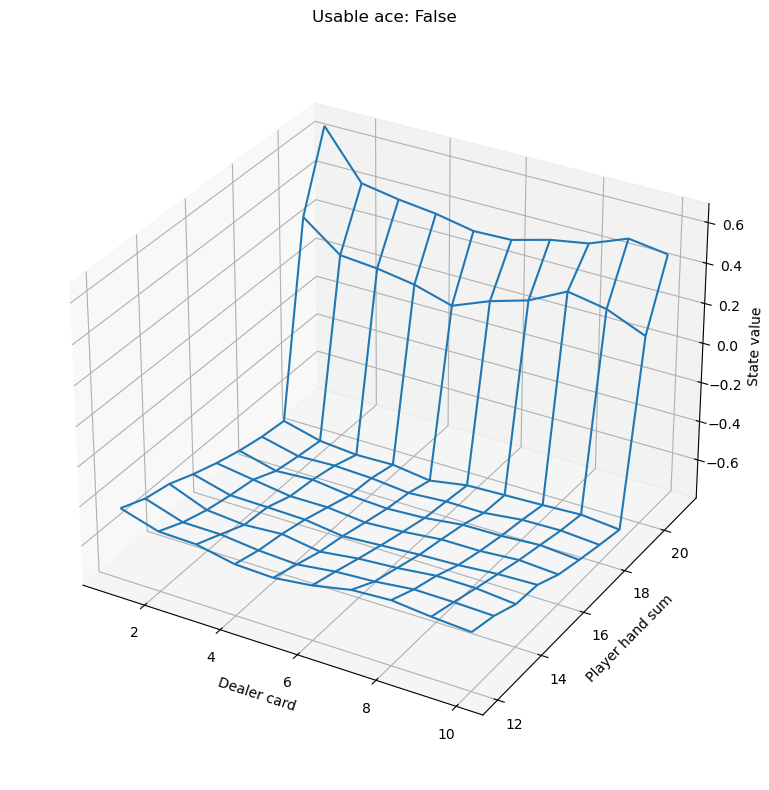

In [7]:
valuePlotsMC(500000, False)

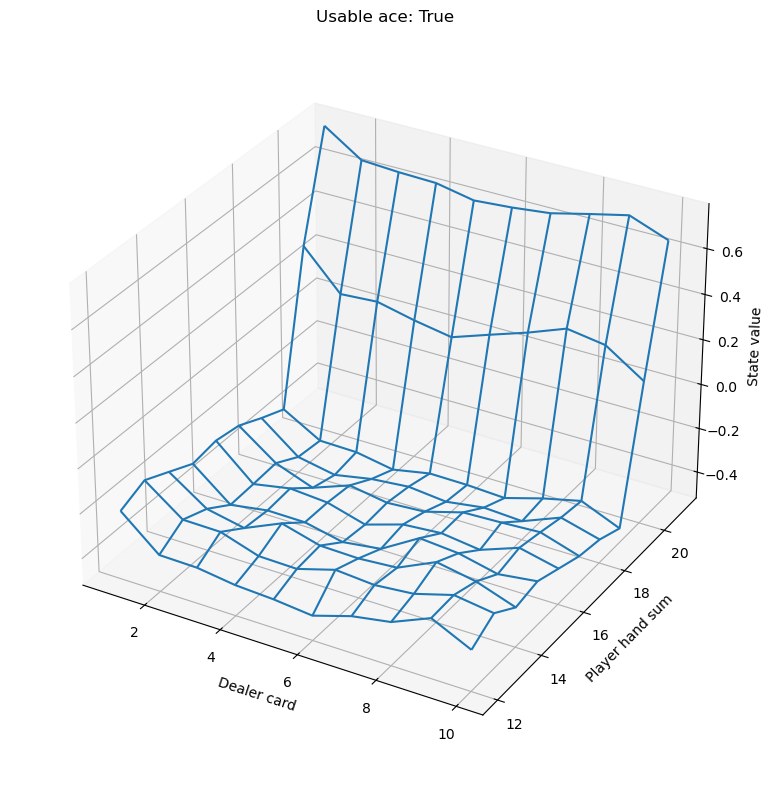

In [8]:
valuePlotsMC(500000, True)